In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os
import scrublet as scr
from wand.image import Image as WImage

In [32]:
sample = snakemake.wildcards.samples
scrub_threshold = snakemake.params.scrub_threshold
# scrub_threshold = ""
# sample = "A"
# os.makedirs(f"{figdir}/{sample}', exist_ok=True)

In [31]:
sc.settings.autosave = True
sc.settings.set_figure_params(dpi=80)
figdir = f"4_Doublets/{sample}"
sc.settings.figdir = figdir
os.makedirs(figdir, exist_ok=True)

In [33]:
adata = sc.read_h5ad(f"3_QC/{sample}_QC.h5ad")

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 36.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.8%
Elapsed time: 3.1 seconds
Predicted 83 doublets


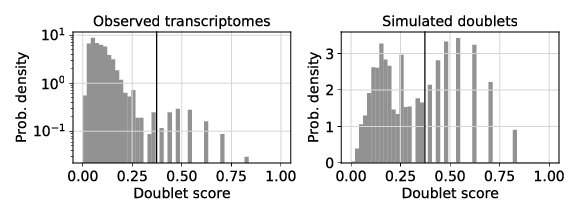

In [34]:
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()

if scrub_threshold:
    adata.obs['predicted_doublets'] = scrub.call_doublets(threshold= scrub_threshold)

histogram, axis = scrub.plot_histogram()


num_predicted_doublets = sum(adata.obs['predicted_doublets'])
print(f"Predicted {num_predicted_doublets} doublets")

histogram.savefig(f"{figdir}/histogram_{sample}_doublets.pdf")
img = WImage(filename=f"{figdir}/histogram_{sample}_doublets.pdf")
img

In [35]:
# add in column with singlet/doublet instead of True/False

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

We should expect that two cells have more detected genes than a single cell, lets check if our predicted doublets also have more detected genes in general

... storing 'doublet_info' as categorical


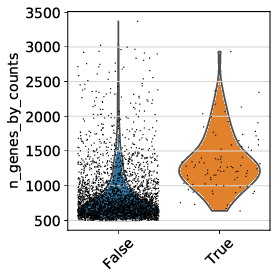

In [36]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45,
            save = f"_{sample}_ngenes_by_counts_doublets.pdf")

img = WImage(filename=f"{figdir}/violin_{sample}_ngenes_by_counts_doublets.pdf")
img

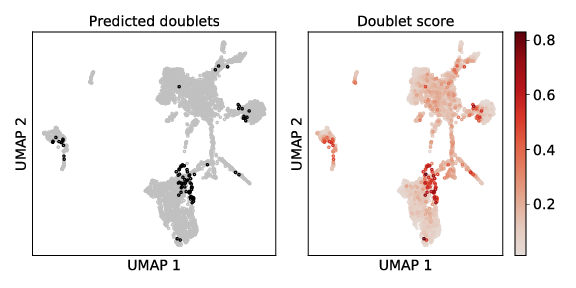

In [37]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
UMAP, axis = scrub.plot_embedding('UMAP', order_points=True);

UMAP.savefig(f"{figdir}/{sample}_doublets.pdf")

img = WImage(filename=f"{figdir}/{sample}_doublets.pdf")
img

In [38]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(3254, 31908)


In [39]:
save_file = f'4_Doublets/{sample}_QC_doublets.h5ad'
adata.write_h5ad(save_file)